# 14_04 분류와 추천 성능 평가지표

In [1]:
# 필요한 패키지 설치 및 임포트
!pip install scikit-plot

import pandas as pd 
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import scikitplot as skplt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

plot_confusion_matrix는 버전 업이 되면서 없어졌기 때문에 ConfusionMatrixDisplay 를 사용한다.

In [2]:
# 데이터 불러오기
# https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
df= pd.read_csv('/Users/adam/Data_Analytics/Python/Datasets/heart_2020_cleaned/heart_2020_cleaned.csv')

# 데이터 샘플 확인
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
# 데이터 전처리

# 명목형 변수 가변수 처리 (하나의 가변수 범주 제거 옵션 적용)
df2 = pd.get_dummies(df, columns = ['HeartDisease','Smoking',
                                    'AlcoholDrinking','Stroke',
                                    'DiffWalking','Sex',
                                    'AgeCategory','Race',
                                    'Diabetic','PhysicalActivity',
                                    'GenHealth','Asthma',
                                    'KidneyDisease','SkinCancer']
                     ,drop_first=True
                    )

# 숫자형 변수 분리
df_num = df[['BMI','PhysicalHealth','MentalHealth','SleepTime']]
df_nom = df2.drop(['BMI','PhysicalHealth','MentalHealth','SleepTime'],axis=1)

# 숫자형 변수 RobustScaler 적용
RobustScaler = RobustScaler()
df_robust = RobustScaler.fit_transform(df_num)

# 컬럼명 결합
df_num2 = pd.DataFrame(data=df_robust, columns=df_num.columns)

# 숫자형 테이블과 더미화 문자형 테이블 결합
df3 = pd.concat([df_num2,df_nom],axis=1)

# 독립변수와 종속변수 분리하여 생성
X = df3.drop(['HeartDisease_Yes'],axis=1)
y = df3[['HeartDisease_Yes']]

# 학습셋과 테스트셋 분리하여 생성(7:3)
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.3,random_state=10)

# 학습셋과 검증셋이 잘 나뉘었는지 확인
print('train data 개수: ', len(X_train))
print('test data 개수: ', len(X_test))

train data 개수:  223856
test data 개수:  95939


In [4]:
# 언더샘플링과 모델 학습 및 예측

# 임시 변수명 적용
X_train_re = X_train.copy()
y_train_re = y_train.copy()

X_temp_name = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10',
            'X11','X12','X13','X14','X15','X16','X17','X18','X19','X20',
            'X21','X22','X23','X24','X25','X26','X27','X28','X29','X30',
            'X31','X32','X33','X34','X35','X36','X37']
y_temp_name = ['y1']

X_train_re.columns = X_temp_name
y_train_re.columns = y_temp_name

# 언더샘플링 적용
X_train_under, y_train_under = RandomUnderSampler(
    random_state=0).fit_resample(X_train_re,y_train_re)

# 컬럼명 복구
X_train_under.columns = list(X_train)
y_train_under.columns = list(y_train)

# 학습셋 모델 학습
model = LogisticRegression()
model.fit(X_train_under, y_train_under)

# 테스트셋에 모델 적용
y_predict = model.predict(X_test)

/Users/adam/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adam/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
# 기본 혼동행렬 출력

cm = confusion_matrix(y_test, y_predict)
print(cm)

[[65337 22390]
 [ 1764  6448]]


In [6]:
# 혼동행렬 데이터 프레임 변환
cm_df = pd.DataFrame(data=cm,
                     index=[f'True Class-{i}' for i in range(cm.shape[0])],
                     columns=[f'Predicted Class-{i}' for i in range(cm.shape[0])])
cm_df    

,Predicted Class-0,Predicted Class-1
True Class-0,65337,22390
True Class-1,1764,6448


Text(0.5, 1.0, 'Confusion Matrix')

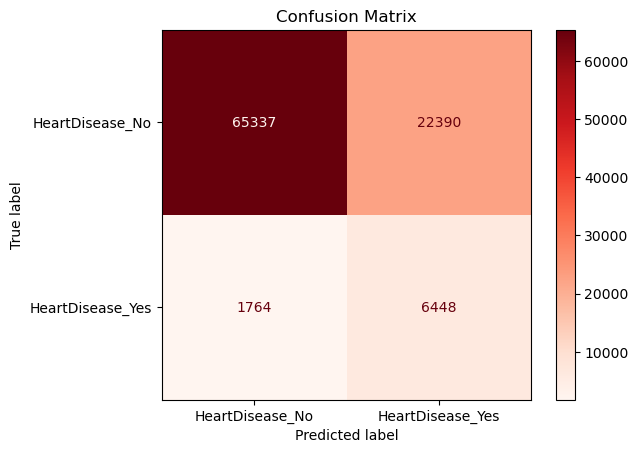

In [7]:
# 혼동행렬 시각화

label=['HeartDisease_No', 'HeartDisease_Yes'] # 라벨 설정
plot = ConfusionMatrixDisplay.from_estimator(model, # 분류 모델
                             X_test, y_test, 
                             display_labels=label, 
                             cmap=plt.cm.Reds, 
                             normalize=None) 
plot.ax_.set_title('Confusion Matrix')

ConfusionMatrixDisplay.from_estimator 를 사용해서 시각화 한다.

In [8]:
# 정확도, 오분류율, 정밀도, 민감도, 특이도, f-1스코어 산출

# 정확도
accuracy = model.score(X_test, y_test)
print('정확도:{:.3f}'.format(accuracy))

# 오분류율
error_rate = 1-model.score(X_test, y_test)
print('오분류율:{:.3f}'.format(error_rate))

# 정밀도
precision = precision_score(y_test, y_predict)
print('정밀도:{:.3f}'.format(precision))

# 민감도(재현율)
recall = recall_score(y_test, y_predict)
print('민감도:{:.3f}'.format(recall))

# 특이도
TN = cm_df['Predicted Class-0'].loc['True Class-0']
FP = cm_df['Predicted Class-1'].loc['True Class-1']
print('특이도:{:.3f}'.format(TN/(TN+FP)))

# f1-스코어
f1 = f1_score(y_test, y_predict)
print('f1-스코어:{:.3f}'.format(f1))

정확도:0.748
오분류율:0.252
정밀도:0.224
민감도:0.785
특이도:0.910
f1-스코어:0.348


In [9]:
# 향상도 테이블 생성

# 예측 스코어 산출 및 결합
probability = model.predict_proba(X_test)
y_probability_df = pd.DataFrame(probability,
                                columns=['probability_0','probability_1'])
y_df = pd.concat([y_test.reset_index()['HeartDisease_Yes'],
                  y_probability_df['probability_1']], axis=1)

# 10분위 컬럼 생성
y_df['decile'] = pd.qcut(y_df['probability_1'],10,
                         labels=['10','9','8','7','6','5','4','3','2','1'])

# 향상도 테이블을 위한 변수 설정
y_all = y_df['HeartDisease_Yes'].sum() # 전체 1값 수
base_lift = y_df['HeartDisease_Yes'
                ].sum()/y_df['HeartDisease_Yes'].count() # 기본 향상도

# 분위수 별 집계
y_df_gb = y_df.groupby(['decile']).agg(
    {'HeartDisease_Yes':'sum','probability_1':'count'}).reset_index()
y_df_gb = y_df_gb.sort_values(by='decile' ,ascending=False)

# 향상도 테이블 요소 생성 및 후처리
y_df_gb['Sensitivity'] = y_df_gb['HeartDisease_Yes']/y_all
y_df_gb['Precision'] = y_df_gb['HeartDisease_Yes']/y_df_gb['probability_1']
y_df_gb['Lift'] = y_df_gb['Precision']/base_lift
y_df_gb = y_df_gb.rename(
    columns={'HeartDisease_Yes':'Frequency of Y=1','probability_1':'Decile count'})

y_df_gb

,decile,Frequency of Y=1,Decile count,Sensitivity,Precision,Lift
9,1,3477,9594,0.423405,0.362414,4.234004
8,2,1816,9594,0.221140,0.189285,2.211375
7,3,1148,9594,0.139795,0.119658,1.397940
6,4,725,9594,0.088285,0.075568,0.882845
5,5,460,9593,0.056016,0.047952,0.560208
4,6,233,9594,0.028373,0.024286,0.283728
3,7,155,9594,0.018875,0.016156,0.188746
2,8,94,9594,0.011447,0.009798,0.114465
1,9,56,9594,0.006819,0.005837,0.068192
0,10,48,9594,0.005845,0.005003,0.058450


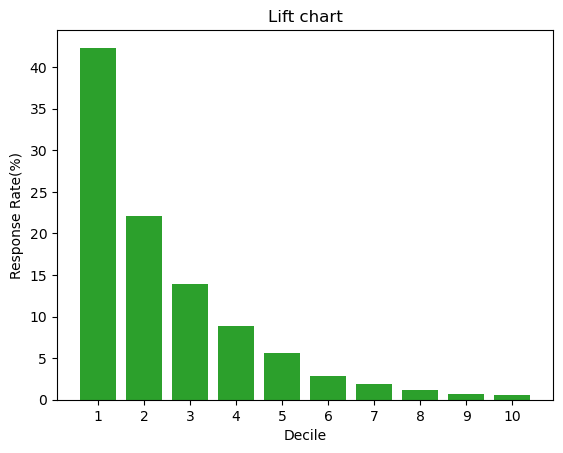

In [10]:
# 향상도 차트 생성
bar_x = np.arange(10)

plt.bar(bar_x, y_df_gb['Sensitivity']*100, color='C2')
plt.xticks(bar_x, y_df_gb['decile'])
plt.title('Lift chart')
plt.xlabel('Decile')
plt.ylabel('Response Rate(%)')

plt.show()

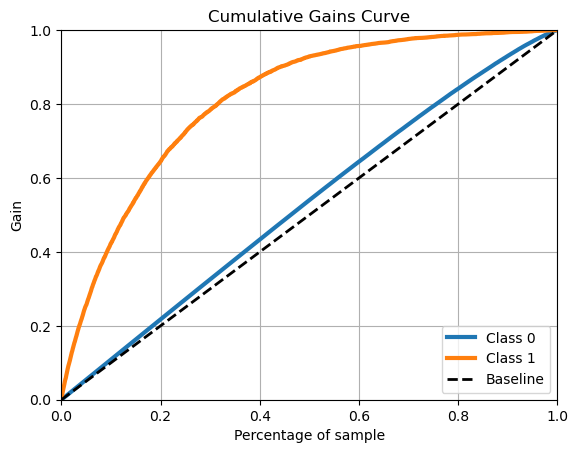

In [11]:
# 누적 향상도 곡선 생성


skplt.metrics.plot_cumulative_gain(y_test, probability)
plt.show()

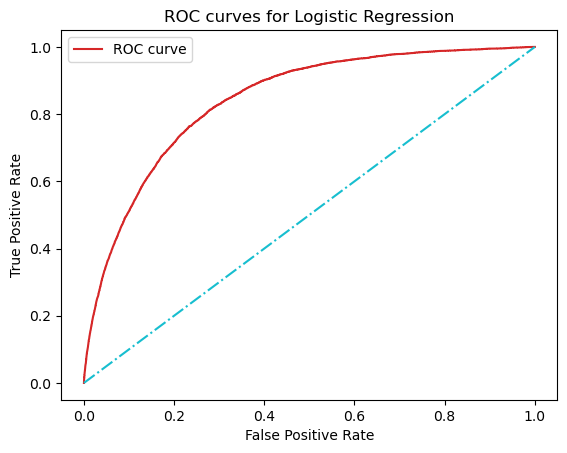

AUC 스코어:0.842


In [12]:
# ROC 커브 생성 및 AUC 스코어 산출

# 시각화 함수 설정
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='C3', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='C9', linestyle='-.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves for Logistic Regression')
    plt.legend()
    plt.show()

# 예측 스코어 전처리 및 ROC 커브 생성
probability_cut = probability[:, 1]
fper, tper, thresholds = roc_curve(y_test, probability_cut)
plot_roc_curve(fper, tper)

# AUC 스코어 산출
auc_score = auc(fper, tper)
print('AUC 스코어:{:.3f}'.format(auc_score))

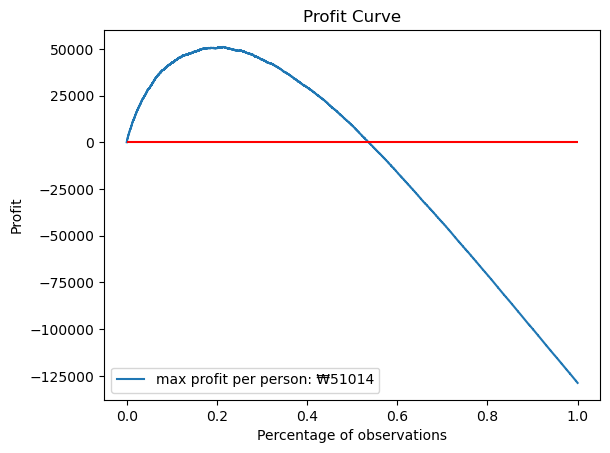

In [14]:
# 수익 곡선

# 수익, 비용 변수 정의
profit = 2000000
cost   = -300000

# 수익, 비용 Matrix 생성
profit_cost_matrix = np.array([[profit+cost, cost],[0,0]])

# 수익곡선 시각화를 위한 혼동행렬 재배열
def cm_for(y_true, y_pred):
    [[tn, fp], [fn, tp]] = metrics.confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

# 예측 스코어 수준 별 예상 수익 값 산출
profits = []
for T in sorted(y_probability_df['probability_1'], reverse=True):
    y_pred_pf = (y_probability_df['probability_1'] > np.array(T)).astype(int)
    confusion_mat = cm_for(y_test, y_pred_pf)
    # 임계값에 대한 총 수익 계산
    profit = sum(sum(confusion_mat * profit_cost_matrix)) / len(y_test)
    profits.append(profit)
    
# 수익곡선 시각화
profit_max = max(profits)
plt.figure();
plt.plot(np.linspace(0, 1, len(y_test)), profits, 
         label = 'max profit per person: ₩{:.0f}'.format(profit_max))
plt.hlines(0,0,1,color="red")
plt.xlabel('Percentage of observations')
plt.ylabel('Profit')
plt.title('Profit Curve')
plt.legend(loc='lower left')
plt.show()

In [17]:
# precision @ k, recall @ k, MAP 산출 (단일 고객 데이터)

# 기존 추천 결과 데이터
actual = ['A','C','D','E','H','M','P','R','S','V']    # 실제 구매 품목
predicted = ['A','D','F','H','M','O','P','X','Z']    # 예측 구매 품목

####################### K 수 지정 ##########################
k = 3    # 평가지표 산출에 사용할 item 수
##########################################################

r = []
rs = [r]

#  예측과 실제 구매 매칭 리스트 생성
for p in predicted:
    if p in actual:
        r.append(1)
    else:
        r.append(0)
        
# precision @ k 산출 함수 설정
def precision_at_k(r, k):
    assert k >= 1    # 설정된 k가 1 이상인지 확인
    # 평가지표 산출에 사용할 결과지 item k개가 0이 아니면 True, 0이면 False
    r = np.asarray(r)[:k] != 0    # 결과지 item 수가 설정한 k 개 보다 적으면 error
    if r.size != k:
        raise ValueError('k setting error')
    return np.mean(r)


# recall @  k  산출 함수 설정
def recall_at_k(r, k):
    assert k >= 1
    all_r = np.sum(r)
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('k setting error')
    return np.sum(r)/all_r

# average precisio 산출 함수 설정
def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

# MAP 산출 함수 설정
def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

print('precision @ k:{:.3f}'.format(precision_at_k(r, k)))
print('recall @ k:{:.3f}'.format(recall_at_k(r, k)))
print('MAP:{:.3f}'.format(mean_average_precision(rs)))

precision @ k:0.667
recall @ k:0.400
MAP:0.853


In [21]:
# precision @ k, recall @ k, MAP 산출 (여러 고객 데이터)

######################## K 수 지정 ###########################
k = 3 # 평가지표 산출에 사용할 item 수
############################################################

# 실제 구매 품목
actual = [['A','C','D','E','H','M','P','R','S','V'],
          ['A','B','C','F','H','M','O','R','T','V'],
          ['C','D','E','F','H','M','O','R','T','V']]

# 예측 구매 품목
predicted = [['A','D','F','H','M','N','O','P','X','Z'],
             ['T','M','D','O','I','X','H','B','A','J'],
             ['F','D','C','I','X','B','E','P','Y','Q']]

rs = []
rrs = [rs]

# 구매 품목 데이터 전처리
for n, items in enumerate(predicted):
    r = []
    for item in items:
        if item in actual[n]:
            r.append(1)
        else:
            r.append(0)
    rs.append(r)
    
# precision @ k 산출 함수 설정
def precision_at_k(rs, k):
    assert k >= 1   # 설정된 k가 1 이상인지 확인
    # 평가지표 산출에 사용할 결과 item k개가 0이 아니면 True, 0이면 False
    rs = np.asarray(rs)[:,:k] != 0
    if rs.shape[1] != k:    # 결과지 item 수가 설정한 k개 보다 적으면 error
        raise ValueError('k setting error')
    return np.mean([np.mean(arr) for arr in rs])

# recall @ k 산출 함수 설정
def recall_at_k(rs, k):
    assert k >= 1
    rs = np.asarray(rs) != 0
    tmp = []
    for arr in rs:
        all_r = np.sum(arr)
        arr = arr[:k] != 0
        if arr.size != k:
            raise ValueError('k setting error')
        tmp.append(np.sum(arr)/all_r)
    return np.mean(tmp)

# average precision 산출 함수 설정
def average_precision(rs):
    rs = np.asarray(rs) != 0
    
    precision_li = []
    for arr in rs:
        tmp = []
        for k in range(arr.size):
            if arr[k]:
                tmp.append(np.mean(arr[:k+1] != 0))
            precision_li.append(np.mean(tmp))
            
    if not precision_li:
        return 0
    return np.mean(precision_li)

# MAP 산출 함수 설정
def mean_average_precision(rss):
    return np.mean([average_precision(r) for r in rrs])

print('precision @ k:{:.3f}'.format(precision_at_k(rs, k)))
print('recall @ k:{:.3f}'.format(recall_at_k(rs, k)))
print('MAP:{:.3f}'.format(mean_average_precision(rrs)))

precision @ k:0.778
recall @ k:0.494
MAP:0.919
